In [1]:
# set the backend
import os

#os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import tensorflow as tf
from tensorflow import data as tf_data

/Users/jcolamendy/python/tutorials/ml-tutorials/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import numpy as np

import keras

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [4]:
def plot_training_curve(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [5]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

2024-04-19 15:41:42.185842: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-19 15:41:42.185906: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-19 15:41:42.185918: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-19 15:41:42.185954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 15:41:42.185973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
print(train_ds)
print(type(train_ds))
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


In [7]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [8]:
print(train_ds)
print(type(train_ds))

<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [9]:
augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [10]:
print(train_ds)
print(type(train_ds))

<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [11]:
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [12]:
print(train_ds)
print(type(train_ds))
print(type(validation_ds))
print(type(test_ds))

<CacheDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
<class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
<class 'tensorflow.python.data.ops.cache_op.CacheDataset'>


In [13]:
# instantiate a base model with pre-trained weights
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# freeze the base model
base_model.trainable = False

# create a new model on top
inputs = keras.Input(shape=(150, 150, 3))
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# show model summary
model.summary(show_trainable=True)

# build the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
print(train_ds)
print(type(train_ds))

<CacheDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<class 'tensorflow.python.data.ops.cache_op.CacheDataset'>


In [15]:
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


2024-04-19 15:48:55.619317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 77/146 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - binary_accuracy: 0.7690 - loss: 0.4079

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/146 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - binary_accuracy: 0.8215 - loss: 0.3300

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


142/146 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - binary_accuracy: 0.8257 - loss: 0.3237

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - binary_accuracy: 0.8268 - loss: 0.3220

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - binary_accuracy: 0.8279 - loss: 0.3204

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 55s 353ms/step - binary_accuracy: 0.8284 - loss: 0.3196 - val_binary_accuracy: 0.9673 - val_loss: 0.0879
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 265ms/step - binary_accuracy: 0.9456 - loss: 0.1290 - val_binary_accuracy: 0.9699 - val_loss: 0.0785
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - binary_accuracy: 0.9517 - loss: 0.1154 - val_binary_accuracy: 0.9729 - val_loss: 0.0757
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - binary_accuracy: 0.9543 - loss: 0.1065 - val_binary_accuracy: 0.9742 - val_loss: 0.0738
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 259ms/step - binary_accuracy: 0.9578 - loss: 0.1010 - val_binary_accuracy: 0.9721 - val_loss: 0.0740
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 264ms/step - binary_accuracy: 0.9623 - loss: 0.0983 - val_binary_accuracy: 0.9712 - val_loss: 0.0754
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - binary_accuracy: 0.9617 - loss: 0.0941 - val_binary_accuracy: 0.9725 - val_loss: 0.0

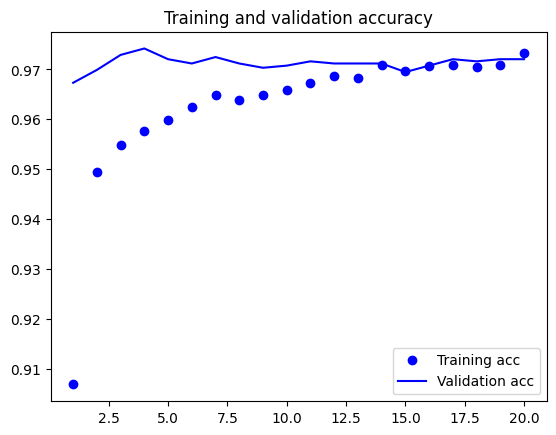

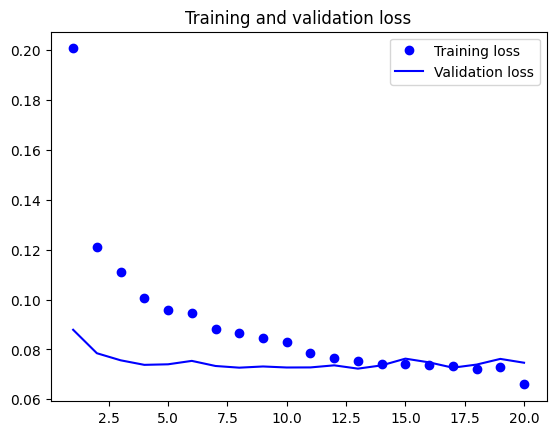

In [16]:
print(history)
plot_training_curve(history)

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
print("Fitting the end-to-end model")
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 62,481,533 (238.35 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 41,618,004 (158.76 MB)

Fitting the end-to-end model
Epoch 1/10
  8/146 ━━━━━━━━━━━━━━━━━━━━ 12:55 6s/step - binary_accuracy: 0.8626 - loss: 0.3749

KeyboardInterrupt: 

In [19]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
 9/37 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - binary_accuracy: 0.9723 - loss: 0.0780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - binary_accuracy: 0.9724 - loss: 0.0772


[0.08315452933311462, 0.9711952209472656]